# Module 8 - Lab - How to Begin Telling a Story with Data

## An Example

This is your final module in the Introduction to Data Science course and by now we have covered enough material for you to begin creating your own analyses and to start telling your own stories. In this module, we are going to outline the steps involved in telling an effective story with data. 

This notebook will serve as an example of story creation by following the steps outlined in the [The 101 Guide to Telling a Compelling Story with Data](https://www.maptive.com/101-guide-telling-compelling-story-data/). This example is, by no means, perfect and there is plenty of room for improvement, which is a vital component to telling stories with data, being open to criticism. This week we will be asking you to do your own steps toward creating your own data driven story and, much like this story, we are not looking for perfection, just an understanding of the techniques that we have learned up until this point.

For the coding aspects of this notebook, much of the logic and reasoning behind the code will be imbedded in the comments within the code blocks. All of the stuff that is done we have learned through this course, and the text within Markdown cells will be emphasizing the steps involved in story creation.  However, if you have any  questions on the code in the notebook, please don’t hesitate to ask.


## Step 1: Find a Story

Imagine the following scenario...

You work for a Film Production company that's been in a rut lately, making mediocre films. You've been tasked with finding the talent for the next great film. Not good... but GREAT! How do you go about doing that?

How about the people? Who makes a great film? You decide to go this direction. **What director and what actor combination do you need to get to in order to ensure that your film is great?** This becomes the central question to your story, but of course, there are several sub-questions that you must answer before getting to your answer.

1. How do we quantify a GREAT film?
2. What are the greatest films?
3. Can we order directors based on their contribution to a film's greatness?
4. Can we order actors/actresses according to their contribution to a film's greatness?

Well, question 1 is easy to answer. "Greatness" is easy to quantify, MONEY! The production company only cares about profits.

## Step 2: Remember your Audience

Catering to your audience is an important aspect of crafting any type of story: data driven stories are no different. But catering to your audience doesn’t mean misleading them. Instead, it is more about the type of information that you present to them, what visuals you provide them, and to what extent you need to describe the details of your analysis. The same story can be told several different ways for several different audiences.


## Step 3: Find Data 

Take a look at the questions in step one. Finding the data that satisfy these questions is the next task. This may involve combining two or more datasets in order to make a better analysis.

The first dataset we would need is one that provides some general features on movies, things such as *movie title*, *director*, *year of release*, *profits*, and *actors/actresses*. Fortunately, there was a compiled dataset from imdb.com hosted on [Kaggle](https://www.kaggle.com/carolzhangdc/imdb-5000-movie-dataset). 

Another thing that we will have to keep in mind is the rate of inflation over the years. The imdb dataset above doesn't adjust for inflation, so we need to find some data on the mean Consumer Price Index through the years, to derive the rate of change, and convert the profits of the films to today's dollars. Fortunately, you can simply find this at the Bureau of Labor Statistics that keeps a record of this type of data.

In [1]:
# Load packages
library(dplyr)
library(ggplot2)
library(ggrepel) # package to visualize text without overlaying them on the points they represent
library(scales)


#Load movie data
Movie.Data <- read.csv("/dsa/data/all_datasets/movie_metadata.csv", header = TRUE, stringsAsFactors = FALSE)

# Load Consumer Price Index data 
cpi <- read.csv('/dsa/data/all_datasets/cpi_per_year.csv',header = TRUE)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
# A little preview of the data sets
head(Movie.Data,2)
head(cpi,2)

color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,⋯,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
<chr>,<chr>,<int>,<int>,<int>,<int>,<chr>,<int>,<int>,<chr>,⋯,<int>,<chr>,<chr>,<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>
Color,James Cameron,723,178,0,855,Joel David Moore,1000,760505847,Action|Adventure|Fantasy|Sci-Fi,⋯,3054,English,USA,PG-13,2.37e+08,2009,936,7.9,1.78,33000
Color,Gore Verbinski,302,169,563,1000,Orlando Bloom,40000,309404152,Action|Adventure|Fantasy,⋯,1238,English,USA,PG-13,3.00e+08,2007,5000,7.1,2.35,0


Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Annual,HALF1,HALF2
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1913,9.8,9.8,9.8,9.8,9.7,9.8,9.9,9.9,10.0,10.0,10.1,10.0,9.9,NA,NA
1914,10.0,9.9,9.9,9.8,9.9,9.9,10.0,10.2,10.2,10.1,10.2,10.1,10.0,NA,NA


## Step 4: Vet Data Sources

The first question we must ask is where did our data come from and is this source reputable? The movie data came from imbd.com, and much like Wikipedia, its users can edit the content. However, that content is checked before it makes it to its site so there is some verification. [Here](http://www.imdb.com/help/show_leaf?infosource&ref_=hlp_brws) is their page on data collection. 

Our data on Consumer Price Index comes from the U.S. Bureau of Labor Statistics, which is a very reputable source. Therefore, our derived inflation rates should be good estimates.  

### A Bit of Data Cleaning

Before we get into the analysis, we need to do some data cleaning and manipulation. 

*Comments in the code will describe what is happening.* 

In [3]:
# Annual average cpi for 2016 is currently empty because the year is not over, so we are 
# going to average the months that we have so far 

cpi2016<-mean(as.numeric(cpi[nrow(cpi),2:13]), na.rm = TRUE) # find average cpi for 2016
cpi[nrow(cpi),14] <- cpi2016  # apply that to the Annual column for 2016

# Need to find the average rate of change with 2016 as the base year. Most years should see 
# a percentage decrease since inflation has increased over the years. The result will be applied
# to monetary columns of the Movie.Data data frame based on year so that we can obtain the dollar 
# value in today's terms

cpi_aves<-cpi[14] # create an object of the average cpis from the cpi data frame
cpi$Inflation <- (cpi_aves - cpi2016)/ cpi2016 # find the rate of change with 2016 being the base year


# Remove the other columns from the cpi frame and call the new frame inflat_year. We will use this to
# merge with the Movie.Data data frame

inflat_year<- cbind(cpi$Year,cpi$Inflation) # join year Column and Inflation column together 
                                            # for future join with Movie.Data

# some renaming of columns of this new frame
inflat_year<-
inflat_year %>%
rename(year = `cpi$Year`, inflat = Annual)

# remame year column of Movie.Data to match the year column name of inflat_year
Movie.Data <- rename(Movie.Data, year=`title_year`)

In [4]:
# merge Movie.Data and inflat_year by year so that every movie has a degree of inflation change assigned 
# in order to find adjusted budget and gross values per film.

Movie.Data<-merge(x = Movie.Data, y = inflat_year, by = "year", type = "left")

# monetary columns adjusted by inflation (represented as 2016 dollars) 
Movie.Data <-
Movie.Data %>%
mutate(budget_adj = budget - (budget * inflat),
      gross_adj = gross - (gross * inflat))

# profit and return on investment using inflation adjusted budget and gross columns
Movie.Data <- Movie.Data %>% 
  mutate(profit = gross - budget,
         profit_adj = gross_adj - budget_adj)
         #return_on_investment_perc = (profit/budget_adj)*100)


# and finally, remove a duplicate column

Movie.Data <- Movie.Data[!duplicated(Movie.Data$movie_title),]

In [5]:
head(Movie.Data,2)

year,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,⋯,budget,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes,inflat,budget_adj,gross_adj,profit,profit_adj
<int>,<chr>,<chr>,<int>,<int>,<int>,<int>,<chr>,<int>,<int>,⋯,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1916,Black and White,D.W. Griffith,69,123,204,9,Mae Marsh,436,NA,⋯,385907,22,8.0,1.33,691,-0.9544456,754234.2,NA,NA,NA
1920,Black and White,Harry F. Millarde,1,110,0,0,Johnnie Walker,2,3000000,⋯,100000,2,4.8,1.33,0,-0.9164139,191641.4,5749242,2900000,5557600


#### Just out of curiosity...
what are the best movies by profit (in today's dollars)?

In [6]:
# Top 20 movies form this dataset when profits are adjusted for inflation

Movie.Data %>%
arrange(desc(profit_adj)) %>% 
select(movie_title, year, profit_adj,imdb_score, actor_1_name) %>%
head(20)

# If you want to see the top 20 movies form this dataset without adjustment
# then uncomment the following block of code

#Movie.Data %>%
#arrange(desc(profit)) %>% 
#select(movie_title, year, profit, imdb_score) %>%
#head(20)

movie_title,year,profit_adj,imdb_score,actor_1_name
<chr>,<int>,<dbl>,<dbl>,<chr>
Star Wars: Episode IV - A New Hope,1977,785917984,8.7,Harrison Ford
E.T. the Extra-Terrestrial,1982,677717218,7.9,Henry Thomas
Titanic,1997,609677128,7.7,Leonardo DiCaprio
Avatar,2009,577628240,7.9,CCH Pounder
The Lion King,1994,521578499,8.5,Matthew Broderick
Jurassic World,2015,506914679,7.0,Bryce Dallas Howard
Star Wars: Episode I - The Phantom Menace,1999,468748403,6.5,Natalie Portman
Star Wars: Episode V - The Empire Strikes Back,1980,450592912,8.8,Harrison Ford
Jaws,1975,447338658,8.0,Roy Scheider


### Question 1: How do we quantify a GREAT film?

Remember back to module 2 where we discussed descriptive statistics. Today we are going to use the Inter Quartile Range to derive those movies that are absolutely great. For this, we want to find those films that are outliers in terms of profits. 

To do that, we are going to use the 3rd quartile + (3 X IQR) where IQR is the interquartile range (the difference between the 3rd quartile and the 1st quartile). Any movie that makes profit higher than this value will be considered GREAT! 

In [7]:
# Find outliers using the IQR 

q1 <- summary(Movie.Data$profit_adj, na.rm = TRUE)[2] # first quartile value
q3 <- summary(Movie.Data$profit_adj, na.rm = TRUE)[5] # third quartile value
iqr <- q3 - q1 # interquartile range
out <-q3 + (3 *iqr) # minimum great value

In [8]:
# Filter movies data based on the outliers found above

the.greats<-
Movie.Data %>%
arrange(desc(profit_adj)) %>% # sort data by profits
select(movie_title, year, profit_adj,imdb_score, actor_1_name) %>% # select these rows from the data
filter(profit_adj > out) # find those movies with profits above the out value found above

head(the.greats,3) # show the first few 
tail(the.greats,3) # show the last few

movie_title,year,profit_adj,imdb_score,actor_1_name
<chr>,<int>,<dbl>,<dbl>,<chr>
Star Wars: Episode IV - A New Hope,1977,785917984,8.7,Harrison Ford
E.T. the Extra-Terrestrial,1982,677717218,7.9,Henry Thomas
Titanic,1997,609677128,7.7,Leonardo DiCaprio


,movie_title,year,profit_adj,imdb_score,actor_1_name
,<chr>,<int>,<dbl>,<dbl>,<chr>
143,Chicago,2002,156872246,7.2,Colm Feore
144,Pitch Perfect 2,2015,155893292,6.5,Anna Kendrick
145,Lethal Weapon 3,1992,155121265,6.7,Rene Russo


### Question 3: Can we order directors based on their contribution to a film's greatness?
#### & 
### Question 4: Can we order actors/actresses according to the contribution to a film's greatness?

Now we have to find the average profit per film for each actor. For simplicity, we can just take the mean. We will consider this their measure of success, the average profits of the films that they play in. The same can be done with directors. We manipulate the data into two separate data frames for easy access to this information.

In [9]:
# Average profits of a film per actor 
Movie.Data.Actors <-
Movie.Data %>% 
  group_by(actor_1_name) %>% # group by actor
  select(actor_1_name, budget_adj, gross_adj, profit_adj) %>% # select these columns
  summarise(films = n(), budget_adj = sum(as.numeric(budget_adj)), # find the number of films per actor and store
            gross_adj = sum(as.numeric(gross_adj)),                # this in a column called films
            profit_adj = sum(as.numeric(profit_adj))) %>%
  filter(films >2, # remove anybody who hasn't been in more than one film, just to clean things up a bit
         actor_1_name != "") %>%  # there are some empty rows in the actor_1_name column. remove these
  mutate(prof_per_film = profit_adj/films) %>% # find the average profit per film of each actor 
  arrange(desc(prof_per_film)) %>% # sort by the prof_per_film
  na.omit()  #remove any na values

# Average profits of a film per director 
Movie.Data.Directors <-
Movie.Data %>% 
  group_by(director_name) %>% # same as above except for directors
  select(director_name, budget_adj, gross_adj, profit_adj) %>%
  summarise(films = n(), budget_adj = sum(as.numeric(budget_adj)), gross_adj = sum(as.numeric(gross_adj)), profit_adj = sum(as.numeric(profit_adj))) %>%
  filter(films >2,
         director_name != "") %>% 
  mutate(prof_per_film = profit_adj/films) %>%
  arrange(desc(prof_per_film)) %>%
  na.omit() 

In [10]:
head(Movie.Data.Actors,2)
head(Movie.Data.Directors,2)

actor_1_name,films,budget_adj,gross_adj,profit_adj,prof_per_film
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Judge Reinhold,3,127183163,741315640,614132477,204710826
Robert Pattinson,7,659335035,1715810885,1056475850,150925121


director_name,films,budget_adj,gross_adj,profit_adj,prof_per_film
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
George Lucas,5,447856392,2470385103,2022528710,404505742
James Cameron,7,973744284,2481542661,1507798377,215399768


### What director and what actor combination do you need to get to in order to ensure that your film is great?

Now you are back to assessing your original question. Well, to answer this, we want the average profit per film to be at least our minimum value of greatness found above (`out`) between our director and actor. This means that if our director on average brings in a profit of less than our minimum value, then our actor is going to have to make more in order to bring us up to the GREAT status! We won't accept anything below.

We can create a matrix of the average profit per pair (*(mean profit per film for director + mean profit per film per actor) / 2*) and then remove any that are below that threshold. What will be returned is a matrix of those combinations of director and actor that would satisify our project of creating a great movie! 

In [11]:
# create an empty matrix that has the same number of rows as the Movie.Data.Actors data frame
# and the same number of columns as the Movie.Data.Directors data frame. We call this mymat

mymat <- matrix(nrow = nrow(Movie.Data.Actors), ncol = nrow(Movie.Data.Directors) )

# now we iterate over our profits per film columns in both the Actors and Directors data frame
# and adding the each value from each column to one another
for (i in 1:dim(mymat)[1]){
    for (j in 1:dim(mymat)[2]){
        mymat[i,j] = (Movie.Data.Actors$prof_per_film[i]+Movie.Data.Directors$prof_per_film[j])/2
    }
    
}

# name the rows in mymat after the actor names
rownames(mymat)<- Movie.Data.Actors$actor_1_name

# name the columns in the mymat after the director names
colnames(mymat)<- Movie.Data.Directors$director_name




In [12]:
# visualize the matrix

mymat


,George Lucas,James Cameron,Joss Whedon,Pete Docter,Francis Lawrence,Leonard Nimoy,John Lasseter,Peter Jackson,Gary Ross,Phil Lord,⋯,Michael Caton-Jones,Danny DeVito,Breck Eisner,Jean-Pierre Jeunet,Sergey Bodrov,Ron Underwood,John Woo,Jean-Marie Poiré,Hayao Miyazaki,Chan-wook Park
Judge Reinhold,304608284,210055297,204555251,191305285,180567095,179481612,163820334,162846295,161446192,161200868,⋯,86981043,83899337,83176845,82055404,81629027,75189955.2,58816932.7,52749011.7,-302959192,-728179652
Robert Pattinson,277715432,183162445,177662399,164412433,153674243,152588759,136927482,135953443,134553340,134308015,⋯,60088191,57006485,56283993,55162552,54736175,48297103.1,31924080.6,25856159.5,-329852045,-755072504
CCH Pounder,270970226,176417239,170917193,157667227,146929036,145843553,130182275,129208237,127808134,127562809,⋯,53342985,50261279,49538787,48417346,47990969,41551896.9,25178874.4,19110953.3,-336597251,-761817710
Michael Gough,268306547,173753560,168253514,155003548,144265357,143179874,127518596,126544558,125144455,124899130,⋯,50679306,47597600,46875108,45753667,45327290,38888218.0,22515195.5,16447274.4,-339260930,-764481389
Paul Hogan,267106400,172553413,167053368,153803402,143065211,141979728,126318450,125344412,123944309,123698984,⋯,49479160,46397454,45674962,44553520,44127143,37688071.7,21315049.3,15247128.2,-340461076,-765681536
Glenn Morshower,261284934,166731947,161231902,147981936,137243745,136158262,120496984,119522946,118122843,117877518,⋯,43657694,40575988,39853496,38732054,38305677,31866605.6,15493583.2,9425662.1,-346282542,-771503002
Macaulay Culkin,257867759,163314772,157814726,144564760,133826570,132741086,117079808,116105770,114705667,114460342,⋯,40240518,37158812,36436320,35314879,34888502,28449430.1,12076407.6,6008486.5,-349699718,-774920177
Nia Vardalos,256833063,162280077,156780031,143530065,132791874,131706391,116045113,115071075,113670972,113425647,⋯,39205823,36124117,35401625,34280183,33853807,27414734.8,11041712.4,4973791.3,-350734413,-775954873
John Ratzenberger,255912465,161359478,155859432,142609466,131871276,130785793,115124515,114150477,112750373,112505049,⋯,38285224,35203519,34481026,33359585,32933208,26494136.4,10121114.0,4053192.9,-351655011,-776875471
Eileen Brennan,254419088,159866101,154366055,141116089,130377898,129292415,113631137,112657099,111256996,111011671,⋯,36791847,33710141,32987649,31866208,31439831,25000758.9,8627736.4,2559815.3,-353148389,-778368848


## Step 5: Filter Results

So, your result come back with 13 different directors and quite a few actors and actresses that could get you to your magic number profit number, but several of these directors are only compatible with only one actor or actress. The movie industry is tough and the more options the better, just in case something falls through.

In order to do this, we are going rearrange our matrix (`mymat`) into long form. What that means is that each column now becomes a value and the values in the matrix become a single column, like so...

In [13]:
library(reshape2) # package to turn matrix in to long form data frame

mat_l <- melt(mymat) # my[mat] [l]ong form

head(mat_l) # take a look at what long form looks like 

# we now need to find those actor/director combos that satisfy our minimum profits
best.comb<- #find the best combinations in long form
mat_l %>%
  rename(actor = Var1, director = Var2, comb_prof = value) %>%
  filter(comb_prof > out) %>%
  arrange(desc(comb_prof)) 

best.comb

Var1,Var2,value
<fct>,<fct>,<dbl>
Judge Reinhold,George Lucas,304608284
Robert Pattinson,George Lucas,277715432
CCH Pounder,George Lucas,270970226
Michael Gough,George Lucas,268306547
Paul Hogan,George Lucas,267106400
Glenn Morshower,George Lucas,261284934


actor,director,comb_prof
<fct>,<fct>,<dbl>
Judge Reinhold,George Lucas,304608284
Robert Pattinson,George Lucas,277715432
CCH Pounder,George Lucas,270970226
Michael Gough,George Lucas,268306547
Paul Hogan,George Lucas,267106400
Glenn Morshower,George Lucas,261284934
Macaulay Culkin,George Lucas,257867759
Nia Vardalos,George Lucas,256833063
John Ratzenberger,George Lucas,255912465


In [14]:
# a data frame of directors and actors and their profits in order to combine
# with our long form data frame
directors <-
Movie.Data.Directors %>%
  select(director = director_name, dir_prof = prof_per_film)

actors <-
Movie.Data.Actors %>%
  select(actor = actor_1_name, act_prof = prof_per_film)

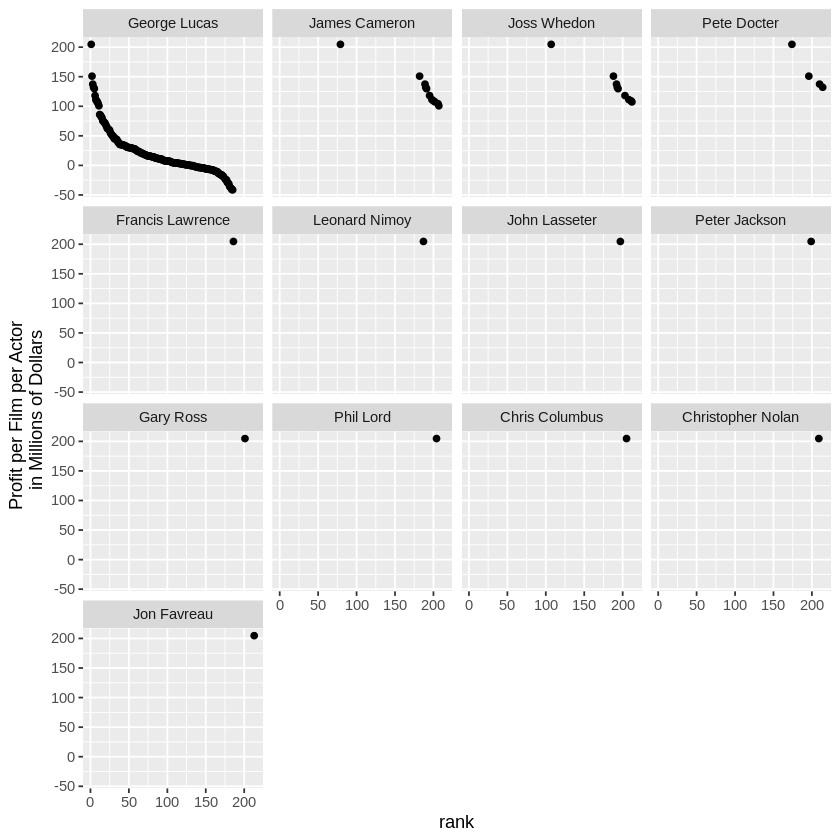

In [15]:
# merge the director and actor frames with the long form
m1 <- merge(x = best.comb, y = directors, by = "director", type = "left")
best.combinations <- merge(x = m1, y = actors, by = "actor", type = "left")

# plot to see how the rank compares with the profit of the actor
# faceted by the director to see which directors give more cushion 
# on our actor choices

best.combinations %>%
    arrange(desc(comb_prof)) %>%
    mutate(rank = row_number())%>% # rank best on combined profit of the actor director combo
    ggplot(aes(x = rank, y = act_prof/1000000)) + geom_point() + 
    facet_wrap(~director) + labs(x="rank", y="Profit per Film per Actor \n in Millions of Dollars")

Looks like the first four plots give us the most leeway in our actor choice, so we will filter out the `best.combination` to include only them. 

In [16]:
flex.directors <-
best.combinations %>%
arrange(desc(comb_prof)) %>% 
mutate(rank = row_number())%>%
filter(director == "George Lucas" | 
       director == "James Cameron" |
       director == "Joss Whedon" |
       director == "Pete Docter")

flex.directors

actor,director,comb_prof,dir_prof,act_prof,rank
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<int>
Judge Reinhold,George Lucas,304608284,404505742,204710826,1
Robert Pattinson,George Lucas,277715432,404505742,150925121,2
CCH Pounder,George Lucas,270970226,404505742,137434709,3
Michael Gough,George Lucas,268306547,404505742,132107351,4
Paul Hogan,George Lucas,267106400,404505742,129707059,5
Glenn Morshower,George Lucas,261284934,404505742,118064127,6
Macaulay Culkin,George Lucas,257867759,404505742,111229775,7
Nia Vardalos,George Lucas,256833063,404505742,109160385,8
John Ratzenberger,George Lucas,255912465,404505742,107319188,9


## Step 6: Visuals

Okay, so we have the major steps of the analysis out of the way. Now we can begin creating some visuals that we might use in our story.

In [17]:
# we can go ahead and create a default theme for our plots
# This is a good technique to do if you need to keep with 
# some type of color scheme, or need to publish in a certain 
# format

library(grid); library(RColorBrewer)

# same theme from module 5
my_theme <- function() {
      
    # Generate the colors for the chart procedurally with RColorBrewer
    palette <- brewer.pal("Greys", n=9) # create a palette of shades of grey 
    color.background = palette[1] # background plot color
    color.grid.major = palette[3] 
    color.grid.minor = palette[2]
    color.axis.text = palette[6] # text color 
    color.axis.title = palette[7]
    color.title = palette[9]

    # Begin construction of chart
    theme_bw(base_size=9) +

    # Set the entire chart region to a light gray color
    theme(panel.background=element_rect(fill=color.background, color=color.background)) +
    theme(plot.background=element_rect(fill=color.background, color=color.background)) +
    theme(panel.border=element_rect(color=color.background)) +

    # Format the grid
    theme(panel.grid.major=element_line(color=color.grid.major,size=.25)) +
    theme(panel.grid.minor=element_blank()) +
    theme(axis.ticks=element_blank()) +

    # Format the legend, but hide by default
    theme(legend.position="bottom") +
    theme(legend.background = element_rect(fill=color.background)) +
    theme(legend.text = element_text(size=7,color=color.axis.title)) +

    # Set title and axis labels, and format these and tick marks
    theme(plot.title=element_text(color=color.title, size=10, vjust=1.25)) +
    theme(axis.text.x=element_text(size=7,color=color.axis.text)) +
    theme(axis.text.y=element_text(size=7,color=color.axis.text)) +
    theme(axis.title.x=element_text(size=8,color=color.axis.title, vjust=0)) +
    theme(axis.title.y=element_text(size=8,color=color.axis.title, vjust=1.25)) +
    
    # Set facet attributes
    theme(strip.background = element_rect(fill=color.background, colour = color.background)) +
    theme(strip.text = element_text(size = 15, colour = color.axis.text)) +

    # Plot margins
    theme(plot.margin = unit(c(0.35, 0.2, 0.3, 0.35), "cm"))
}

It would be good to first visualize the distribution of profits. We can do a boxplot and label those top movies (the movies we are aiming for).

Warning message:
“Removed 1036 rows containing non-finite values (stat_boxplot).”

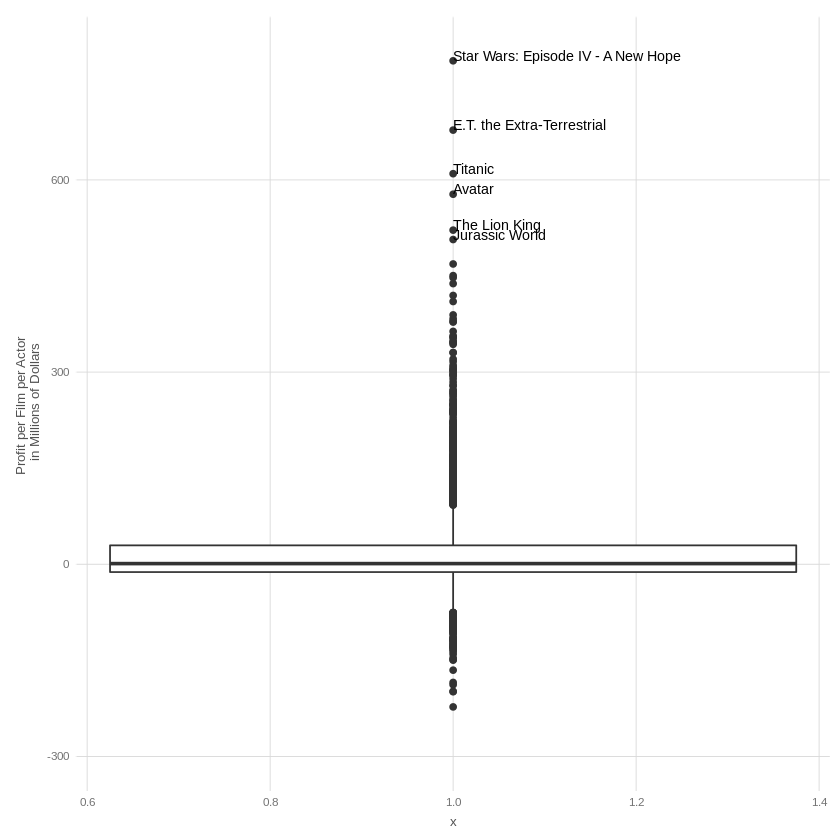

In [18]:
best <-
Movie.Data %>%
filter(profit_adj > 500000000)


ggplot(Movie.Data, aes(x = 1, y = profit_adj/1000000)) + geom_boxplot() + 
    geom_text(data = best,aes(label = movie_title),hjust=0, vjust=0, size = 3)+
    scale_y_continuous(limits = c(-300, 800))+ labs( y="Profit per Film per Actor \n in Millions of Dollars") + 
    my_theme()

The take a look at the directors who can work with multiple actor/actresses and still get us to our target goal of $154,640,000 of profit. 

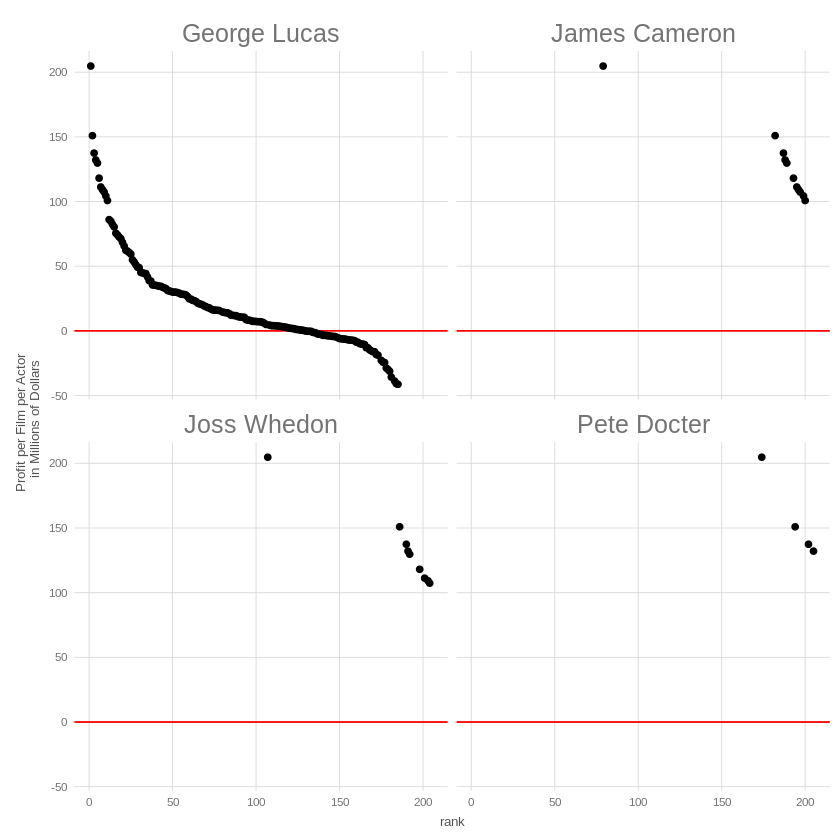

In [19]:
flex.directors %>%
    arrange(desc(comb_prof)) %>%
    mutate(rank = row_number())%>% # rank best on combined profit of the actor director combo
    ggplot(aes(x = rank, y = act_prof/1000000))+ geom_hline(yintercept = 0, colour = "red") + geom_point() + 
    facet_wrap(~director) + labs(x="rank", y="Profit per Film per Actor \n in Millions of Dollars") +
    my_theme()

We can tackle the beast that is George Lucas in a bit; but first, let’s see who the actors are that can work with the other three directors.

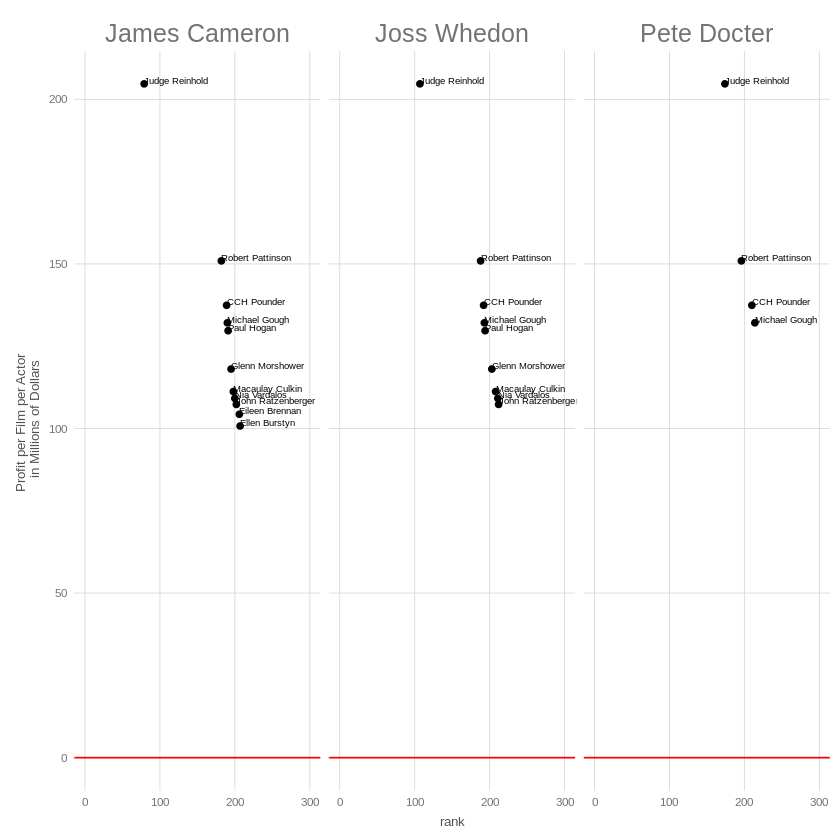

In [20]:
flex.directors %>%
    filter(director == "James Cameron" |
       director == "Joss Whedon" |
       director == "Pete Docter") %>%
    ggplot(aes(x = rank, y = act_prof/1000000))+ geom_hline(yintercept = 0, colour = "red") + geom_point() + 
    scale_x_continuous(limits = c(0, 300))+
    facet_wrap(~director) + labs(x="rank", y="Profit per Film per Actor \n in Millions of Dollars") + 
    geom_text(aes(label = actor), size = 2,hjust=0, vjust=0) +
    my_theme()


Well, all three of these directors can work with Judge Reinhold, Robert Pattinson and C.C.H. Pounder, and could have worked with Michael Gough when he was alive.  Out of the three, James Cameron looks like he can work with more, simply because he tends to bring more money in himself. But let’s take a look at George Lucas…

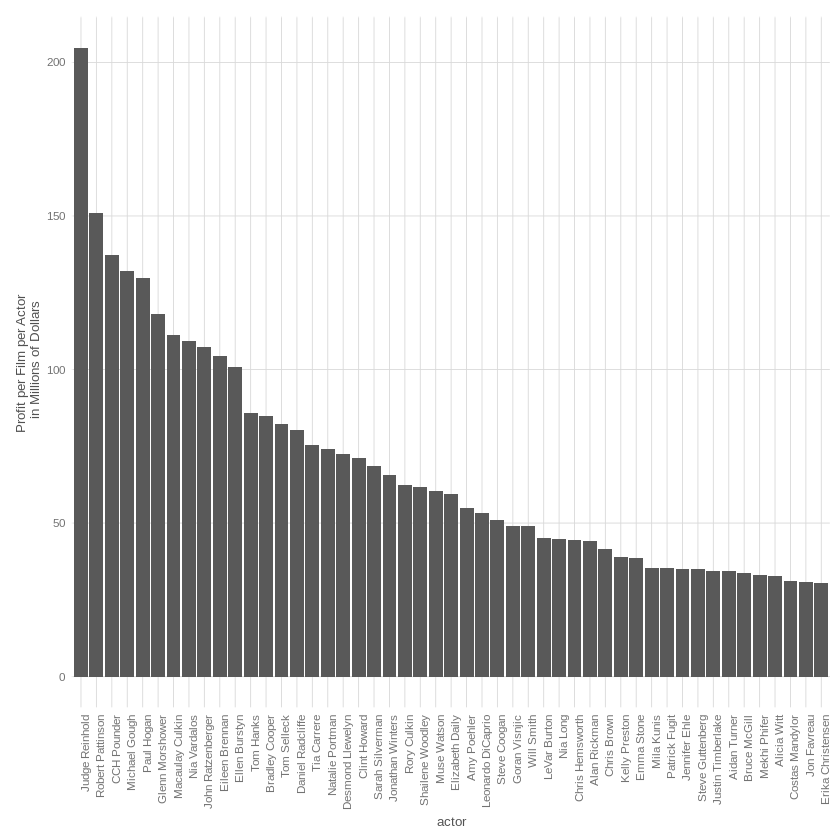

In [21]:
flex.directors %>% 
    filter(director == "George Lucas" &
           rank < 50) %>% # he can work with so many actors that we have to split his data
            ggplot(aes(x = actor, y = act_prof/1000000)) + geom_bar(stat = "identity") + my_theme() +
            theme(axis.text.x = element_text(angle = 90, hjust = 1), legend.position = "None") +
            labs( y="Profit per Film per Actor \n in Millions of Dollars")

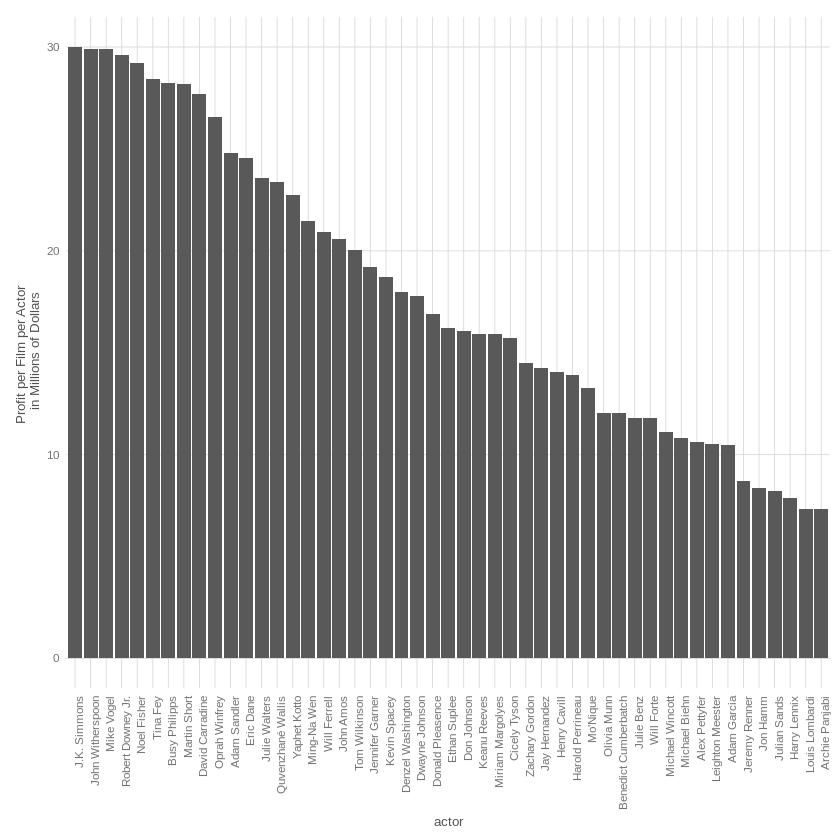

In [22]:
flex.directors %>% 
    filter(director == "George Lucas" &
           rank >= 50 & rank < 100) %>%
            ggplot(aes(x = actor, y = act_prof/1000000)) + geom_bar(stat = "identity") + my_theme() +
            theme(axis.text.x = element_text(angle = 90, hjust = 1), legend.position = "None") +
            labs( y="Profit per Film per Actor \n in Millions of Dollars")


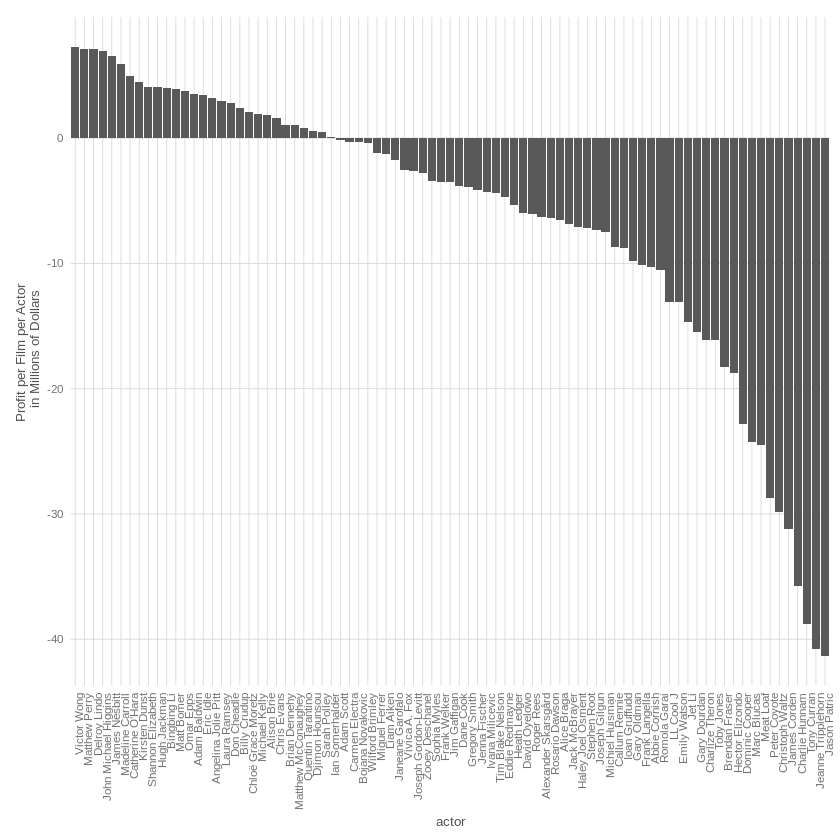

In [23]:
flex.directors %>% 
    filter(director == "George Lucas" &
           rank >=  100) %>%
            ggplot(aes(x = actor, y = act_prof/1000000)) + geom_bar(stat = "identity") + my_theme() +
            theme(axis.text.x = element_text(angle = 90, hjust = 1), legend.position = "None") +
            labs( y="Profit per Film per Actor \n in Millions of Dollars")

He can work with all these people. He even brings in enough money that he can work with those actors and actresses whose films they have acted in have resulted in an average loss of profit. Anything below the red line indicates those actors and actresses. He's obviously the director we want to pursue for our new movie. But just how much profit are we looking to make?

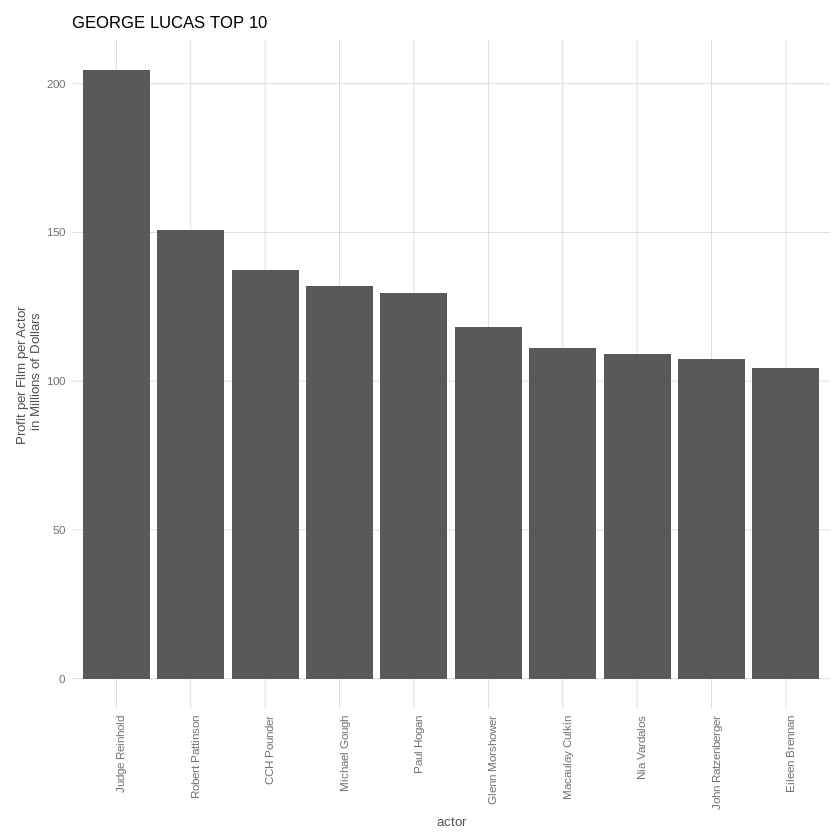

In [24]:
flex.directors %>% 
    filter(rank <=  10) %>%
    ggplot(aes(x = actor, y = act_prof/1000000)) + geom_bar(stat = "identity") + my_theme() +
            theme(axis.text.x = element_text(angle = 90, hjust = 1), legend.position = "None") +
            labs( y="Profit per Film per Actor \n in Millions of Dollars") + ggtitle("GEORGE LUCAS TOP 10")

Now these are the actors/actresses we want to pursue for our movie. In combination with George Lucas, they could bring our company some large profits!

## Step 7 - Craft the Story

This is left undone for this lab. What you would want to do is use all that is above and shape a data driven story to a selected audience. This is a critical step as what is above is notes and not something that is usually for consumption by others. 

## Concluding Remarks

It is always good to be thinking about how you could improve your analysis. Obviously, a film isn’t just its director and first actor. Instead, there are a lot of factors that contribute to a successful film and accounting for these would make for a much more convincing story, things such as second and third actor, or writer.  This is where feature selection techniques come in handy and could make your analysis a lot more convincing, particularly when describing your results to more quantitatively savvy people.

There are other ways we could better this model. We could have made it probabilistic instead of saying that these actors and directors would guarantee us these profits. The question could become, what is the probability that this pair, given the actor’s history of film profits and the director’s, will bring in X amount of dollars. This would be a lot more convincing. We would then pursue those with the highest probability in bringing in X amount of profit.

Finally, visualizations could always be improved. Interactive visualizations, which we didn’t cover in this course, would be a particularly good way to visualize this type of information.
